In [392]:
import json
import numpy as np
import pandas as pd
from shapely.geometry import shape, Polygon, Point

Load GeoJson Powiat info

In [393]:
df = pd.read_json('../../data/3. data_auxiliary/powiaty-max.txt')

df["name"] = ""
df["shape"] = ""
df["polygon"] = ""
df["centroid"] = ""
# df["area"] = ""
df["convex_hull"] = ""

for i, row in df.iterrows():
    row["name"] = row['features']["properties"]["nazwa"]
    shpe = shape(row['features']["geometry"])
    row["shape"] = shpe
    row["polygon"] = shpe.buffer(0)
    row["centroid"] = shpe.centroid
    # row["area"] = shpe.area
    row["convex_hull"] = shpe.convex_hull

df["name"] = df["name"].str.lower()
df.drop(columns=["type", "features"], inplace=True)
# df.head(3)

In [394]:
# Replace powiat name "powiat jeleniogórski" with "powiat karkonoski" (renamed in 2021)
idx = df.index[df['name']=="powiat jeleniogórski"].item()
df.at[idx,"name"] = "powiat karkonoski"

Load GeoJson voivodeship info

In [395]:
df2 = pd.read_json('../../data/3. data_auxiliary/wojewodztwa-max.txt')

df2["name"] = ""
df2["shape"] = ""

for _, row in df2.iterrows():
    row["name"] = row['features']["properties"]["nazwa"]
    row["shape"] = shape(row['features']["geometry"])

df2 = df2.drop(columns=["type", "features"])
# df2.head()

Add voievodeship to powiats

In [396]:
def getVoivodeship(centroid):
    for _, row2 in df2.iterrows():
        if row2["shape"].contains(centroid):
            return (row2["name"], row2["shape"])

df["voivodeship"] = ""
df["voivodeship_shape"] = ""

for i, row in df.iterrows():
    df.at[i,"voivodeship"], df.at[i,"voivodeship_shape"] = getVoivodeship(row["centroid"])
# df.head(3)

In [397]:
# GeoJson voivodeship df no longer needed
del(df2)

Add isUrban flag

In [398]:
# /src/tasks/task-3-eda/8.%20Adding%20isUrban.ipynb
urban_powiats = set(['powiat biała podlaska, lubelskie', 
       'powiat białystok, podlaskie',
       'powiat bielsko-biała, śląskie',
       'powiat bydgoszcz, kujawsko-pomorskie', 
       'powiat chełm, lubelskie',
       'powiat częstochowa, śląskie',
       'powiat dąbrowa górnicza, śląskie',
       'powiat elbląg, warmińsko-mazurskie',
       'powiat gdańsk, pomorskie',
       'powiat gdynia, pomorskie',
       'powiat gliwice, śląskie', 
       'powiat gorzów wielkopolski, lubuskie',
       'powiat grudziądz, kujawsko-pomorskie',
       'powiat jelenia góra, dolnośląskie',
       'powiat kalisz, wielkopolskie',
       'powiat katowice, śląskie',
       'powiat kielce, świętokrzyskie',
       'powiat konin, wielkopolskie',
       'powiat koszalin, zachodniopomorskie',
       'powiat kraków, małopolskie',
       'powiat krosno, podkarpackie',
       'powiat legnica, dolnośląskie', 
       'powiat leszno, wielkopolskie',
       'powiat lublin, lubelskie', 
       'powiat nowy sącz, małopolskie',
       'powiat olsztyn, warmińsko-mazurskie',
       'powiat opole, opolskie',
       'powiat ostrołęka, mazowieckie',
       'powiat piotrków trybunalski, łódzkie',
       'powiat poznań, wielkopolskie',
       'powiat przemyśl, podkarpackie',
       'powiat płock, mazowieckie', 
       'powiat radom, mazowieckie',
       'powiat rybnik, śląskie',
       'powiat rzeszów, podkarpackie',
       'powiat siedlce, mazowieckie',
       'powiat skierniewice, łódzkie',
       'powiat suwałki, podlaskie', 
       'powiat szczecin, zachodniopomorskie',
       'powiat słupsk, pomorskie', 
       'powiat tarnobrzeg, podkarpackie',
       'powiat tarnów, małopolskie', 
       'powiat toruń, kujawsko-pomorskie',
       'powiat warszawa, mazowieckie',
       'powiat wałbrzych, dolnośląskie',
       'powiat wrocław, dolnośląskie',
       'powiat włocławek, kujawsko-pomorskie',
       'powiat zabrze, śląskie',
       'powiat zamość, lubelskie',
       'powiat zielona góra, lubuskie',
       'powiat łomża, podlaskie',
       'powiat łódź, łódzkie',
       'powiat żory, śląskie'])

In [399]:
df['isUrban'] = df['name'] + ', ' + df['voivodeship']
df['isUrban'] = df['isUrban'].apply(lambda x: 1 if x in urban_powiats else 0)

Add population density

In [400]:
df3 = pd.read_excel('../../data/4. data_processed/static_annual_data/population_density_by_powiat.xlsx')
df3 = df3[["County Name", "Voivodeship", "Unnamed: 9"]]
df3 = df3.drop([0,1,2])
df3.rename(columns = {'County Name':'name', 'Voivodeship':'voivodeship', 'Unnamed: 9':'density'}, inplace = True)

df3["name"] = df3["name"].str.lower()

In [401]:
# Replace powiat name "powiat jeleniogórski" with "powiat karkonoski" (renamed in 2021)
idx = df3.index[df3['name']=="powiat jeleniogórski"].item()
df3.at[idx,"name"] = "powiat karkonoski"

In [402]:
# Merge in populaiton density
df = df.merge(df3, how="left", left_on=["name", "voivodeship"], right_on=["name", "voivodeship"])

In [403]:
del(df3)

Add powiat area

In [404]:
df4 = pd.read_excel('../../data/4. data_processed/static_annual_data/area_by_powiat.xlsx')
df4 = df4[["County Name", "Voivodeship", "Unnamed: 9"]]
df4.rename(columns = {'County Name':'name', 'Voivodeship':'voivodeship', 'Unnamed: 9':'area'}, inplace = True)
df4 = df4.drop([0,1,2])

df4["name"] = df4["name"].str.lower()
# df4.head()

In [405]:
# Replace powiat name "powiat jeleniogórski" with "powiat karkonoski"
idx = df4.index[df4['name']=="powiat jeleniogórski"].item()
df4.at[idx,"name"] = "powiat karkonoski"

In [406]:
# Merge in area
df = df.merge(df4, how="left", left_on=["name", "voivodeship"], right_on=["name", "voivodeship"])

In [407]:
del(df4)

In [408]:
# Compute total population by powiat ( population_density * area )
df['population'] = (df["density"] * df["area"])

Compute voivodeship population density

In [409]:
# Compute total population by voivodship
df["voivodeship_populaiton"] = df.groupby(["voivodeship"])["population"].transform("sum")

# Compute total area by voivodship
df["voivodeship_area"] = df.groupby(["voivodeship"])["area"].transform("sum")

# Compute voivodship population density
df["voivodeship_density"] = df["voivodeship_populaiton"] / df["voivodeship_area"]

In [410]:
df_voivod = df[["voivodeship", "voivodeship_shape", "voivodeship_density"]].groupby(by="voivodeship").head(1)

Plotting common functions

In [411]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches

def getCAQILevelColor(CAQI_idx):
    if CAQI_idx<=25:
        return '#5cbb55'
    elif (CAQI_idx>25) & (CAQI_idx<=50):
        return '#a4d52a'
    elif (CAQI_idx>50) & (CAQI_idx<=75):
        return '#e2c801'
    elif (CAQI_idx>75) & (CAQI_idx<=100):
        return '#eb9500'
    elif CAQI_idx>100:
        return '#e53d67'

def colorFader(c1,c2,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    c1=np.array(mpl.colors.to_rgb(c1))
    c2=np.array(mpl.colors.to_rgb(c2))
    return mpl.colors.to_hex((1-mix)*c1 + mix*c2)

def plotShapeContour(shape, color="black", linewidth=.3):
    if shape.geom_type == "MultiPolygon":
        for geom in shape.geoms:
            x, y = geom.exterior.xy
            plt.plot(x,y,c=color,linewidth=linewidth)
    elif shape.geom_type == "Polygon":
        x,y = shape.exterior.xy
        plt.plot(x,y,c=color,linewidth=linewidth)

def plotShapeFill(shape, color, alpha=1):
    if shape.geom_type == "MultiPolygon":
        for geom in shape.geoms:
            x, y = geom.exterior.xy
            plt.fill(x, y, alpha=alpha, c=color, ec='none')
    elif shape.geom_type == "Polygon":
        x,y = shape.exterior.xy
        plt.fill(x, y, alpha=alpha, c=color, ec='none')

def plotPowiatVoivodContours():
    # plot powiat contours
    for _, row in df.iterrows():
        plotShapeContour(row["shape"])

    # plot voivodeship contours
    for _, row in df_voivod.iterrows():
        plotShapeContour(row["voivodeship_shape"], linewidth=1)

def plotCommonConfig():
    plt.rcParams['figure.figsize'] = [15, 14]
    plt.xlim([14, 24.3])
    plt.ylim([49,55])
    plt.axis("off")

### Plot Urban / Non-urban areas

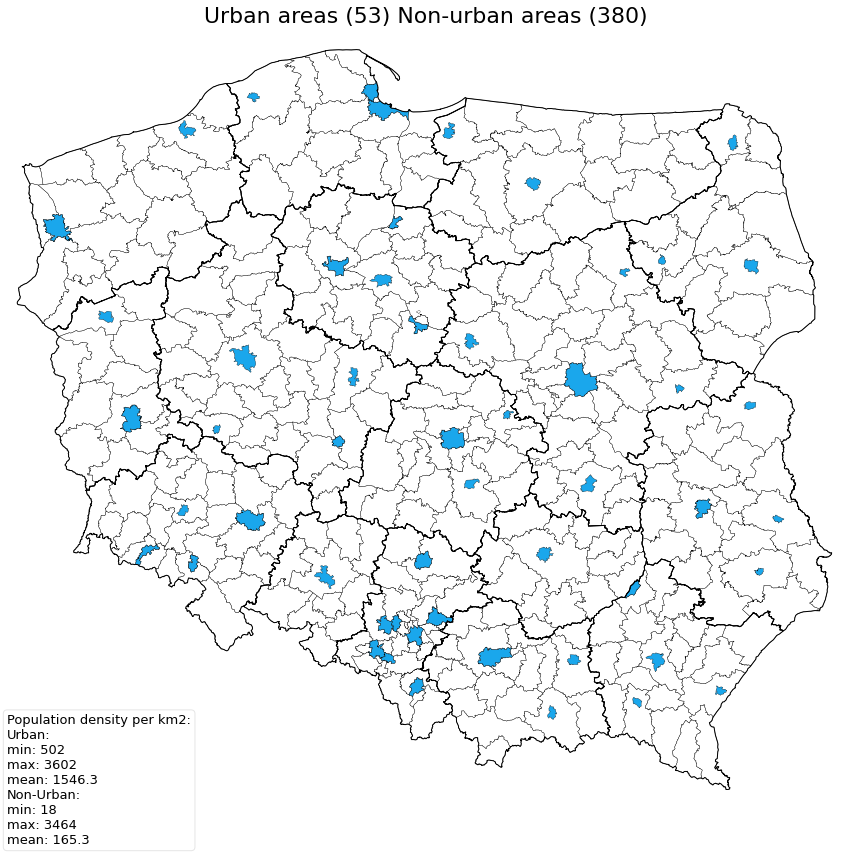

In [412]:
plotCommonConfig()
plt.title("Urban areas (" + str(df[df["isUrban"]==1].shape[0]) + ") Non-urban areas (" + str(df.shape[0]) + ")", size=22)

plotPowiatVoivodContours()

# plot urban powiats
for i, row in df.iterrows():
    if row['isUrban'] == 1:
        plotShapeFill(row["shape"], color="#1AA7EC")

# text box
text = "Population density per km2:\n"
text += "Urban:\n"
text += "min: " + str(df.groupby(['isUrban'])['density'].min()[1]) + "\n"
text += "max: " + str(df.groupby(['isUrban'])['density'].max()[1]) + "\n"
text += "mean: " + str(np.round(df.groupby(['isUrban'])['density'].mean()[1], 1)) + "\n"
text += "Non-Urban:\n"
text += "min: " + str(df.groupby(['isUrban'])['density'].min()[0]) + "\n"
text += "max: " + str(df.groupby(['isUrban'])['density'].max()[0]) + "\n"
text += "mean: " + str(np.round(df.groupby(['isUrban'])['density'].mean()[0], 1))

plt.text(14, 49.6, text, size=13,
         ha="left", va="top",
         bbox=dict(boxstyle="round",
                   ec="gray",
                   fc="white",
                   alpha=0.2
                   )
        )
# plt.savefig('urban_non_urban_areas.png', facecolor="white", bbox_inches='tight')
plt.show()


### Plot voivodeship populaiton density

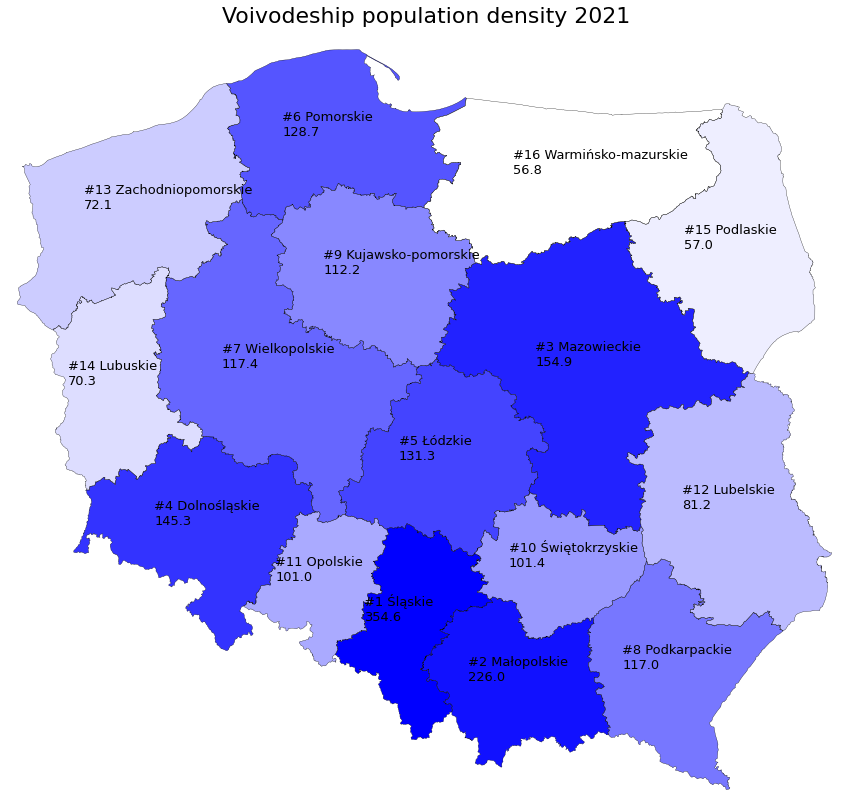

In [413]:
plotCommonConfig()
plt.title("Voivodeship population density 2021", size=22)

# fader colors init
c1='blue'
c2='white'
n=df_voivod.shape[0]-1

# plot powiat contours
for _, row in df_voivod.iterrows():
    plotShapeContour(row["voivodeship_shape"])

# plot top population density powiats
i=0
for index, row in df_voivod.sort_values("voivodeship_density", ascending=False).iterrows():
    plotShapeFill(row["voivodeship_shape"], color=colorFader(c1,c2,i/n))        
    annotation = "#"+str(i+1) + " " + row['voivodeship'][0].upper() + row['voivodeship'][1:] + '\n'
    annotation+= str(round(row["voivodeship_density"],1))
    plt.annotate(annotation, xy=(row["voivodeship_shape"].centroid.x-.6,row["voivodeship_shape"].centroid.y), fontsize=13)
    i += 1

# plt.savefig('voivod_pop_density', facecolor="white", bbox_inches='tight')
plt.show()

In [414]:
# df_tmp = df8[["voivodeship", "voivodeship_density"]]
# df_tmp.head()
# df_tmp.to_csv("voivodeship_popultion_density.csv")

### Plot how many powiats are covered by the final dataset

In [415]:
# Load final dataset
df_final = pd.read_csv('../../data/7. final_data/aq_weather_static_data_with_caqi_fixed_norm.csv')

In [416]:
# Compute list of poowiats present in the final dataset
df5 = df_final[["powiat_voivod"]].groupby("powiat_voivod").head(1)

final_list_of_powiats = df5["powiat_voivod"].unique()
# cover for "powiat jeleniogórski" being renamed to "powiat karkonoski" in 2021
final_list_of_powiats[final_list_of_powiats == "powiat jeleniogórski, dolnośląskie"] = "powiat karkonoski, dolnośląskie";

In [417]:
del(df5)

### Plot the powiats present in the final dataset

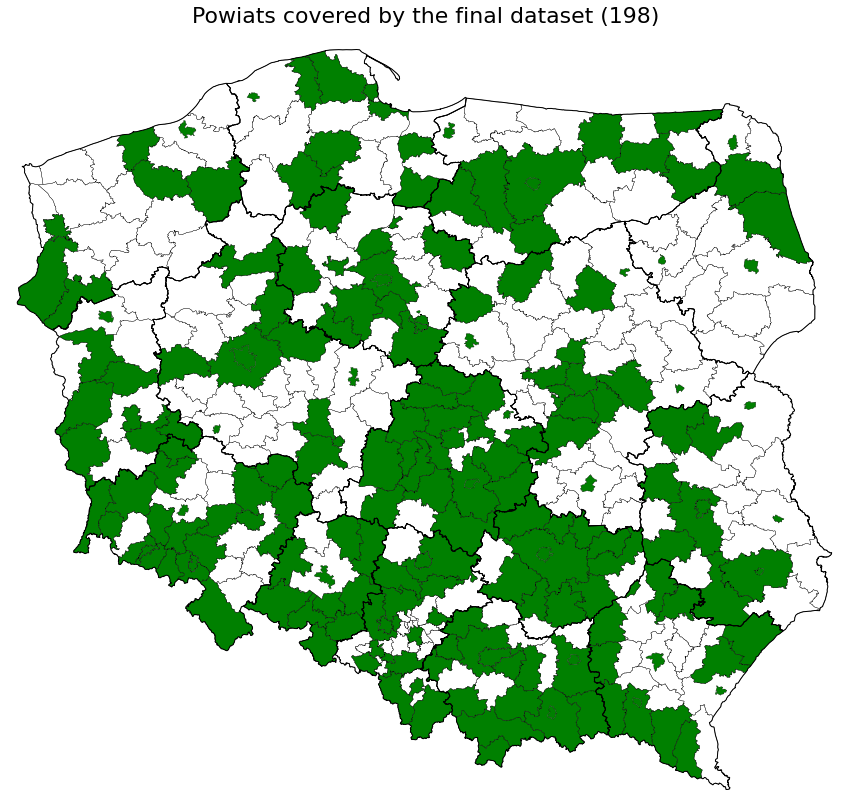

In [418]:
plotCommonConfig()
plotPowiatVoivodContours()

# Due to the nature of powiat shapes some non-urban powiats include urban ones
# Step 1: draw non-urban powits in the final dataset,
# Step 2: remove the urban patches inside
# Step 3: draw urban powiats in the final dataset
# NB: All urban powiats are present in the final dataset, so this technique isn't necessary

# Step 1: plot non-urban powiat
count = 0
for _, row in df.iterrows():
    if row["isUrban"]==0:
        if row["name"] + ", " + row["voivodeship"] in final_list_of_powiats:
            count+=1
            plotShapeFill(row["shape"], color="green")

# Step 2: remove urban patches
for _, row in df.iterrows():
    if row["isUrban"]==1:
        plotShapeFill(row["shape"], color="white")

# Step 3: draw urban powiats in the final dataset
for _, row in df.iterrows():
    if row["isUrban"]==1:
        if row["name"] + ", " + row["voivodeship"] in final_list_of_powiats:
            count+=1
            plotShapeFill(row["shape"], color="green")

plt.title("Powiats covered by the final dataset ("+str(count)+")", size=22)
# plt.savefig('final_dataset_coverage.png', facecolor="white", bbox_inches='tight')
plt.show()

### Plot the number of powiats per voivodeship covered by the final dataset

In [419]:
# total number of powiats per voivodeship
df5 = df[["name", "voivodeship"]].groupby("voivodeship").count().reset_index()

# Number of powiats by voivodeship covered by the final dataset
df6 = df_final[["powiat_voivod"]].groupby("powiat_voivod").head(1)
df6 = df6["powiat_voivod"].str.split(',', expand=True).groupby(1).count().reset_index()

df6.columns = ['voivodeship', 'final_dataset_count']
df6["voivodeship"] = df6["voivodeship"].str.strip()

df7 = df5.merge(df6, how="inner", on="voivodeship")
df7.rename(columns={'name':'powiat_count'}, inplace=True)
df7["rate"] = df7["powiat_count"] / df7["final_dataset_count"]

del(df5, df6)
# df7.head()

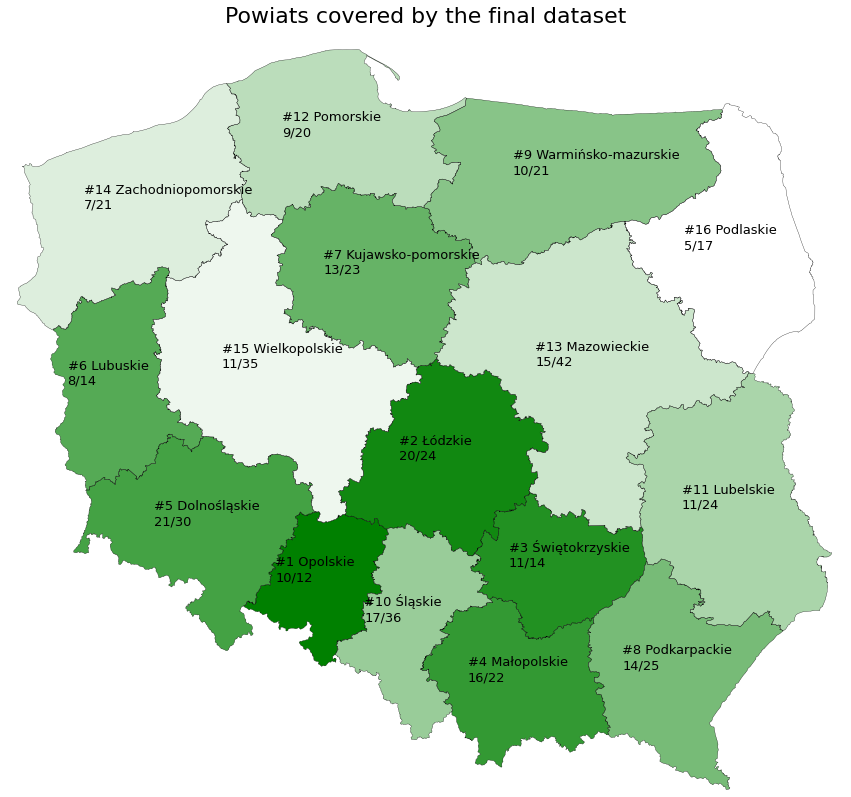

In [420]:
plotCommonConfig()
plt.title("Powiats covered by the final dataset", size=22)

# color fader init
c1='green'
c2='white'
n=df_voivod.shape[0]-1

# plot all powiat contours
for _, row in df_voivod.iterrows():
    plotShapeContour(row["voivodeship_shape"])

# plot top population density powiats
i=0
for _, row in df7.sort_values("rate").iterrows():
    voivodeship_shape = df[df["voivodeship"]==row["voivodeship"]].head(1)["voivodeship_shape"].item()
    plotShapeFill(voivodeship_shape, color=colorFader(c1,c2,i/n))
    annotation = "#"+str(i+1) + " " + row['voivodeship'][0].upper() + row['voivodeship'][1:] + '\n' + str(row["final_dataset_count"]) + "/" + str(row["powiat_count"])
    plt.annotate(annotation, xy=(voivodeship_shape.centroid.x-.6,voivodeship_shape.centroid.y),fontsize=13)
    i += 1

# plt.savefig('final_dataset_coverage_voivod.png', facecolor="white", bbox_inches='tight')
plt.show()

### Plot CAQI Means at voivodeship level
Normally CAQI is represented as a maximum value

In [421]:
df9 = df_final[["powiat_voivod", "CAQI_idx"]]
df9.loc[:,'voivodeship'] = df9.loc[:,"powiat_voivod"].str.split(', ', expand=True)[1]

c:\Users\Catalin\Soft\anaconda3\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [422]:
df9 = df9.groupby(["voivodeship"])["CAQI_idx"].mean().reset_index().sort_values("CAQI_idx", ascending=False)
df9["CAQI_idx"] = df9["CAQI_idx"].round(2)

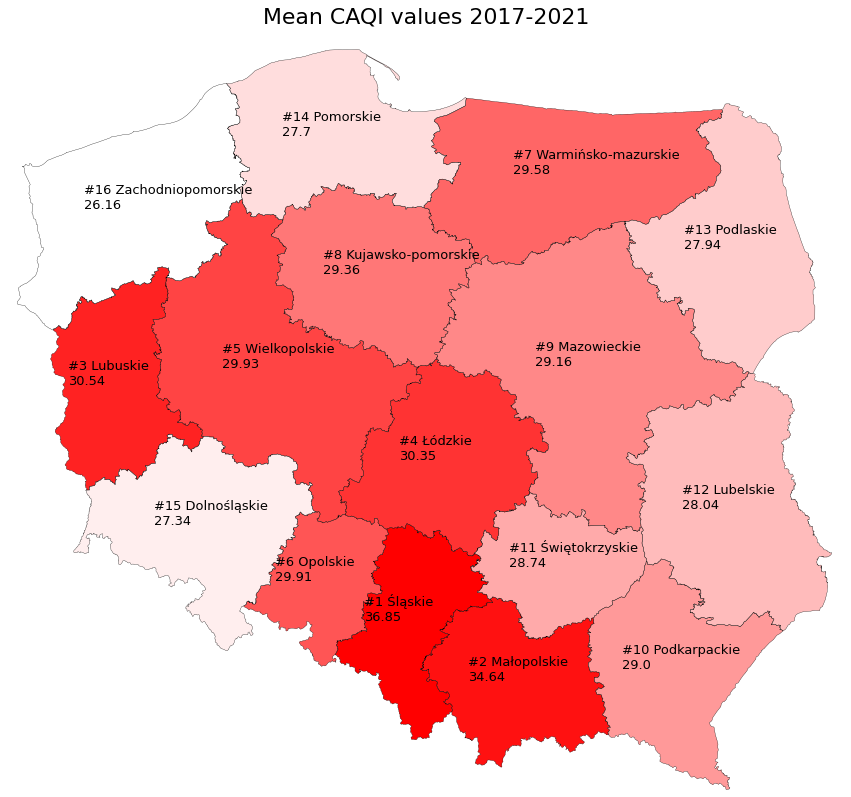

In [423]:
plotCommonConfig()
plt.title("Mean CAQI values 2017-2021", size=22)

# color fader init
c1='red'
c2='white'
n=df_voivod.shape[0]-1

# plot all voivodeship contours
for _, row in df_voivod.iterrows():
    plotShapeContour(row["voivodeship_shape"])

# plot top population density powiats
i=0
for index, row in df9.iterrows():
    voivodeship_shape = df[df["voivodeship"]==row["voivodeship"]].head(1)["voivodeship_shape"].item()
    plotShapeFill(voivodeship_shape, color=colorFader(c1,c2,i/n))
    annotation = "#"+str(i+1) + " " + row['voivodeship'][0].upper() + row['voivodeship'][1:] + '\n' + str(row["CAQI_idx"])
    plt.annotate(annotation, xy=(voivodeship_shape.centroid.x-.6,voivodeship_shape.centroid.y),fontsize=13)
    i += 1

plt.show()


### Highest Mean CAQI

In [424]:
df10 = df_final[["powiat_voivod", "CAQI_idx", "isUrban"]]
df10 = df10.groupby(["powiat_voivod", "isUrban"])["CAQI_idx"].mean().reset_index().sort_values("CAQI_idx", ascending=False)
df10["CAQI_idx"] = df10["CAQI_idx"].round(2)

In [425]:
# Replace powiat name "powiat jeleniogórski" with "powiat karkonoski" (renamed in 2021)
idx = df10.index[df10['powiat_voivod']=="powiat jeleniogórski, dolnośląskie"].item()
df10.at[idx,"powiat_voivod"] = "powiat karkonoski, dolnośląskie"

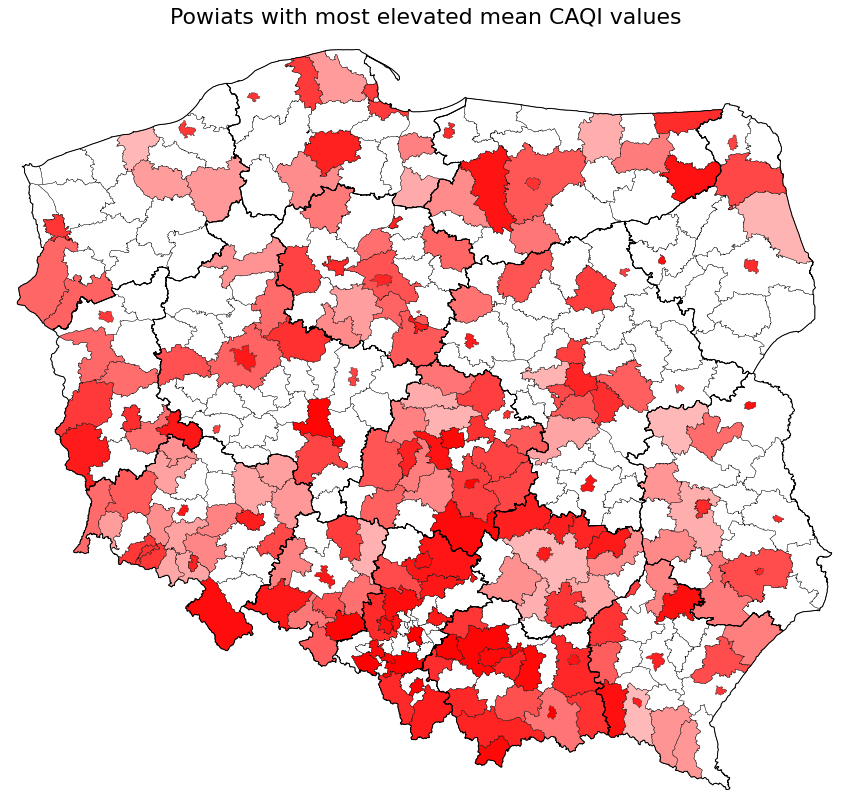

In [426]:
plotCommonConfig()
plotPowiatVoivodContours()
plt.title("Powiats with most elevated mean CAQI values", size=22)

# color fader init
c1='red'
c2='white'
n=df10.shape[0]

# Step 1: plot non-urban powiat
i = 0
for _, row in df10.iterrows():
    if row["isUrban"]==0:
        powiat, voivodeship = row["powiat_voivod"].split(", ")
        shape = df[(df["name"]==powiat) & (df["voivodeship"]==voivodeship)].head(1)["shape"].item()
        plotShapeFill(shape, color=colorFader(c1,c2,i/n))
        i+=1

# Step 2: remove urban patches
for _, row in df.iterrows():
    if row["isUrban"]==1:
        plotShapeFill(row["shape"], color="white")

# Step 3: draw urban powiats
i = 0
for _, row in df10.iterrows():
    if row["isUrban"]==1:
        powiat, voivodeship = row["powiat_voivod"].split(", ")
        shape = df[(df["name"]==powiat) & (df["voivodeship"]==voivodeship)].head(1)["shape"].item()
        plotShapeFill(shape, color=colorFader(c1,c2,i/n))
        i+=1

# plt.savefig('most_elevated_caqi_values.png', facecolor="white", bbox_inches='tight')
plt.show()

In [427]:
print("min CAQI: " + str(df10["CAQI_idx"].min()))
print("max CAQI: " + str(df10["CAQI_idx"].max()))

min CAQI: 18.34
max CAQI: 43.08


### Mean CAQI levels for
* the entire period 
* for winter
* during the lockdown
* highest day on record

In [428]:
def winterPeriod(main_df):
    df = main_df.copy()
    df["month"] = pd.to_datetime(df['DATE']).dt.strftime('%b')
    df = df[df["month"].isin(["Dec", "Jan", "Feb"])]
    return df

def lockdownPeriod(main_df):
    df = main_df.copy()
    df["DATE"] = pd.to_datetime(df['DATE'])
    mask = (
        (df['DATE'] > "2020-03-12") & (df['DATE'] <= "2020-05-30") | \
        (df['DATE'] > "2020-10-24") & (df['DATE'] <= "2021-02-01") | \
        (df['DATE'] > "2021-03-25") & (df['DATE'] <= "2021-05-01")
    )
    df = df.loc[mask]
    return df

def highestDay(main_df):
    df = main_df.copy()
    mask = (
        (df['DATE'] == "2017-02-15")
        # (df['DATE'] == "2017-02-16") | \
        # (df['DATE'] == "2017-02-14")
    )
    df = df.loc[mask]
    return df

def meanCAQIByPowiat(main_df):
    df = main_df.copy()
    df = df[["powiat_voivod", "CAQI_idx", "isUrban"]]
    df = df.groupby(["powiat_voivod", "isUrban"])["CAQI_idx"].mean().reset_index().sort_values("CAQI_idx", ascending=False)
    df["CAQI_idx"] = df["CAQI_idx"].round(2)
    return df

# Replace powiat name "powiat jeleniogórski" with "powiat karkonoski" (renamed in 2021)
def replacePowiat(main_df):
    df = main_df.copy()
    idx = df.index[df['powiat_voivod']=="powiat jeleniogórski, dolnośląskie"].item()
    df.at[idx,"powiat_voivod"] = "powiat karkonoski, dolnośląskie"
    return df

In [429]:
df11 = (df_final
      .pipe(winterPeriod)
      .pipe(meanCAQIByPowiat)
      .pipe(replacePowiat)
      )

df12 = (df_final
      .pipe(lockdownPeriod)
      .pipe(meanCAQIByPowiat)
      .pipe(replacePowiat)
      )

df13 = (df_final
      .pipe(highestDay)
      .pipe(meanCAQIByPowiat)
      .pipe(replacePowiat)
      )

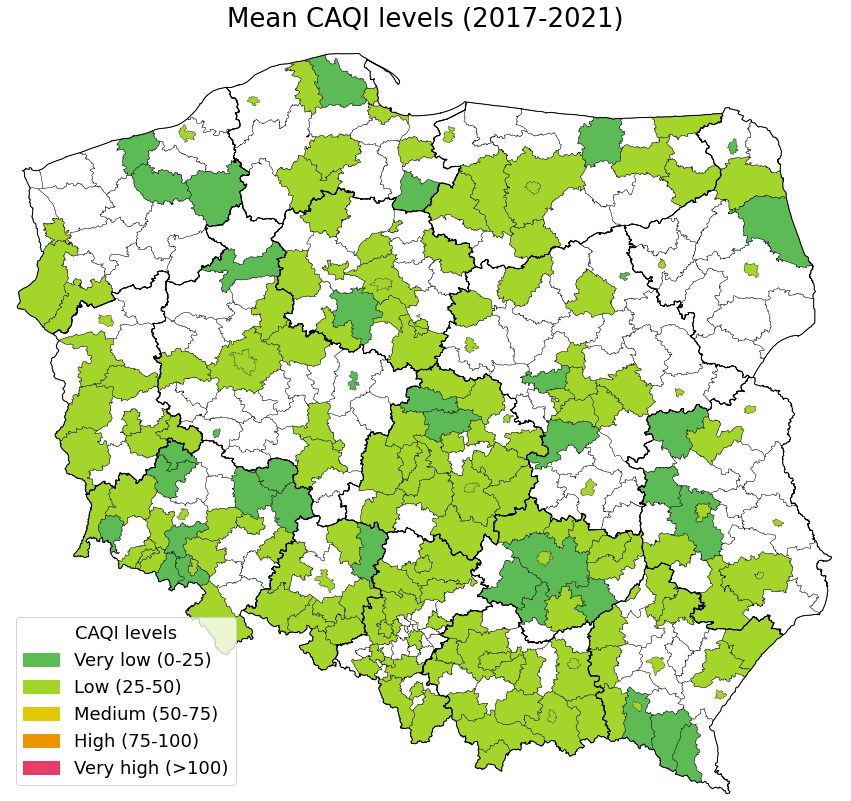

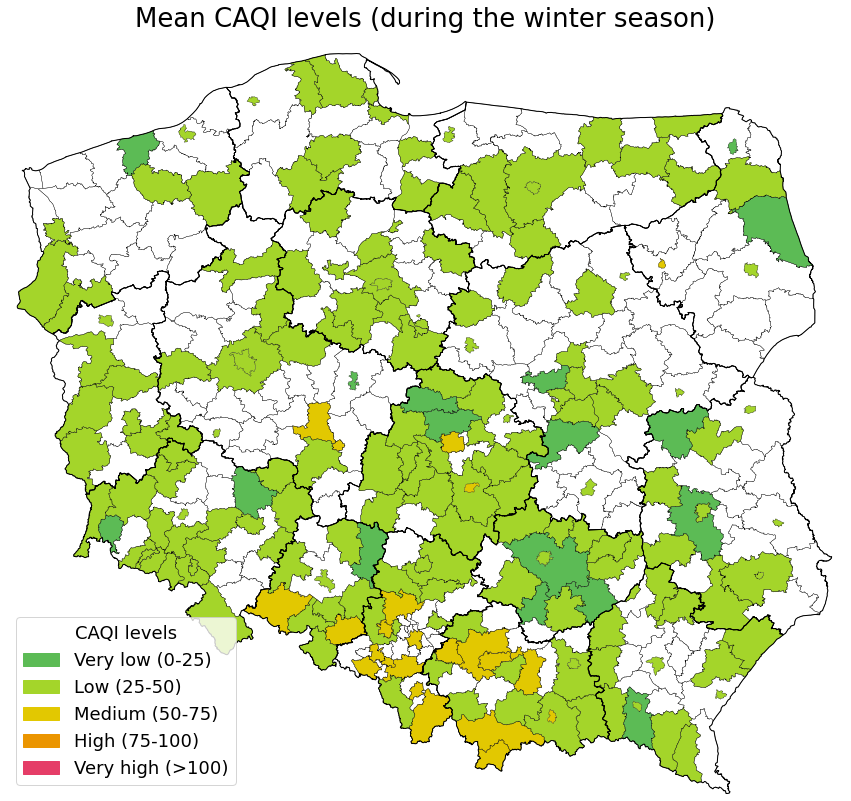

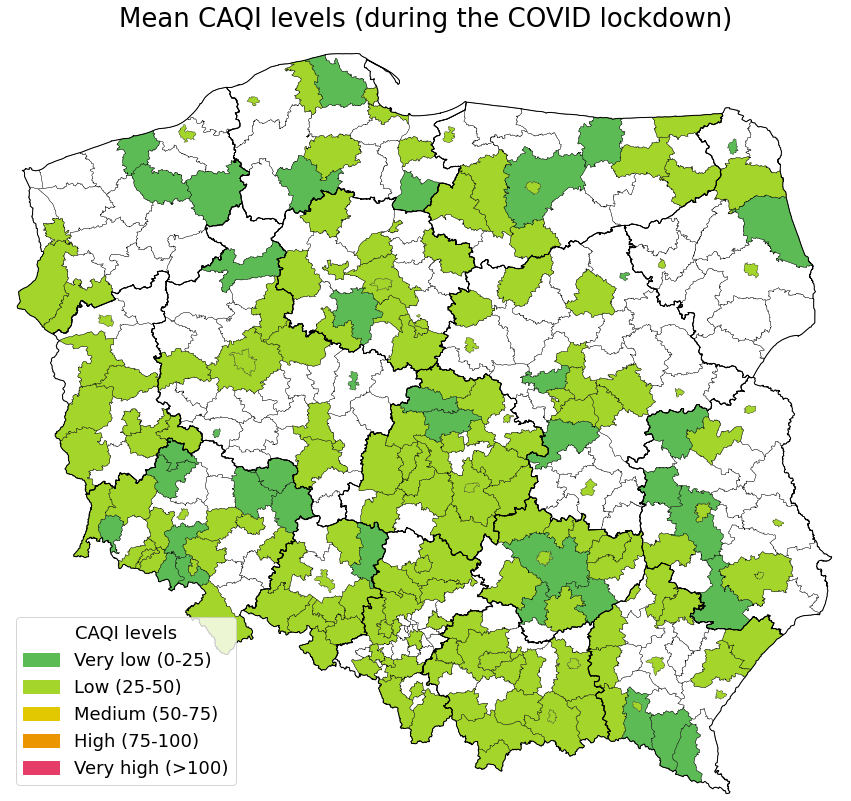

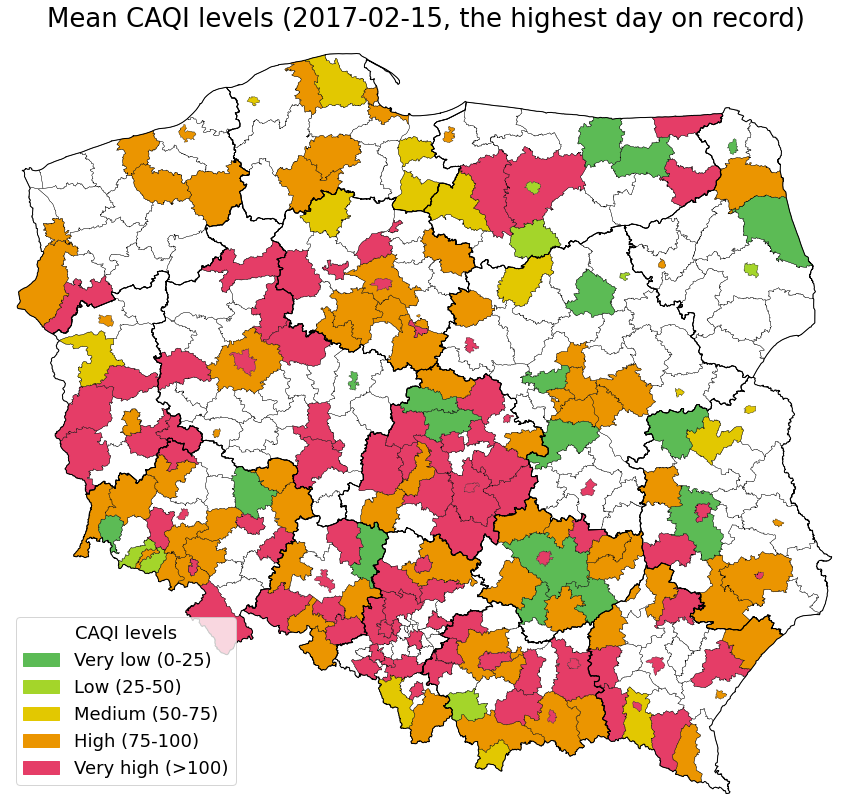

In [430]:
#custom legend handles
vlow_patch = mpatches.Patch(color='#5cbb55', label='Very low (0-25)')
low_patch = mpatches.Patch(color='#a4d52a', label='Low (25-50)')
med_patch = mpatches.Patch(color='#e2c801', label='Medium (50-75)')
high_patch = mpatches.Patch(color='#eb9500', label='High (75-100)')
vhigh_patch = mpatches.Patch(color='#e53d67', label='Very high (>100)')

handles = [vlow_patch, low_patch, med_patch, high_patch, vhigh_patch]
titles = {
    0:"Mean CAQI levels (2017-2021)", 
    1:"Mean CAQI levels (during the winter season)", 
    2:"Mean CAQI levels (during the COVID lockdown)", 
    3:"Mean CAQI levels (2017-02-15, the highest day on record)"
}
filenames = {
    0:"mean_caqi_values.png",
    1:"mean_caqi_values_winter.png",
    2:"mean_caqi_values_lockdown.png",
    3:"mean_caqi_values_highest_day.png"
}

for i in range(4):
    plotCommonConfig()
    plotPowiatVoivodContours()
    
    plt.title(titles[i], size=26)

    # Step 1: plot non-urban powiat
    for _, row in eval("df1"+str(i)).iterrows():
        if row["isUrban"]==0:
            powiat, voivodeship = row["powiat_voivod"].split(", ")
            shape = df[(df["name"]==powiat) & (df["voivodeship"]==voivodeship)].head(1)["shape"].item()
            plotShapeFill(shape, color=getCAQILevelColor(row["CAQI_idx"]))

    # Step 2: remove urban patches
    for _, row in df.iterrows():
        if row["isUrban"]==1:
            plotShapeFill(row["shape"], color="white")

    # Step 3: draw urban powiats
    for _, row in eval("df1"+str(i)).iterrows():
        if row["isUrban"]==1:
            powiat, voivodeship = row["powiat_voivod"].split(", ")
            shape = df[(df["name"]==powiat) & (df["voivodeship"]==voivodeship)].head(1)["shape"].item()
            plotShapeFill(shape, color=getCAQILevelColor(row["CAQI_idx"]))

    #custom legend
    plt.legend(handles=handles, title="CAQI levels", title_fontsize=18, loc="lower left", fontsize=18, fancybox=True)

    plt.savefig(filenames[i], facecolor="white", bbox_inches='tight')
    plt.show()